# CDAW CME Catalog Analysis Notebook
This notebook is for some very light analysis of calculated durations is conducted near the end of the notebook.

In [1]:
import pandas as pd

CME_Catalog_Filename = '../cme_event_catalog.csv'
Raw_CME_Catalog_Filename = '../raw_cme_event_catalog.csv'
Full_CME_Catalog_Filename = '../full_cme_event_catalog.csv'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot_data (xdata, ydata, xlabel="", ylabel="", title="", alpha=1.0):

    fig, ax = plt.subplots()
    #plt.style.use('fivethirtyeight')
    
    ax.plot(xdata, ydata, 'ro', alpha=alpha)
    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    
def plot_hist(data, what, nbins:int=100, ylog:bool=False, xlow:int=0, xhigh:int=None, nofill:bool=False):
    
    fig, ax = plt.subplots()
        
    if nofill:
        data.hist(ax=ax, bins=nbins, bottom=0, fill=None)
    else:
        data.hist(ax=ax, bins=nbins, bottom=0)
    ax.set_title("Histogram")
    ax.set(xlabel=what, ylabel="Num/bin")
    
    if xlow != None and xhigh != None:
        plt.xlim(xlow, xhigh)
        
    #plt.xticks(rotation=90)
    
    #plt.style.use('fivethirtyeight')
    if ylog:
        ax.set_yscale('log')
        #ax.set_xscale('log')

In [3]:
data = pd.read_csv(Full_CME_Catalog_Filename)
len(data)

22051

In plots below we compare different durations to see if they indicate 
different underlying populations of CME being detected. A comparison of the peaks 
shows that they are basically the same underlying population and we may combine
different C2, C3 classifiers later on to detect CME. 

X-axis scale is the same for easier comparison. C3 data statistics are too poor.

In [4]:
# Split into detector specific datasets
c2_data = data[data.Remarks.str.contains('Only C2')]
c3_data = data[data.Remarks.str.contains('Only C3')]
c2_c3_data = data[data.Remarks.str.contains('Only C2') == False]
c2_c3_data = c2_c3_data[c2_c3_data.Remarks.str.contains('Only C3') == False]
len(c2_data), len(c3_data), len(c2_c3_data)

(10591, 362, 11098)

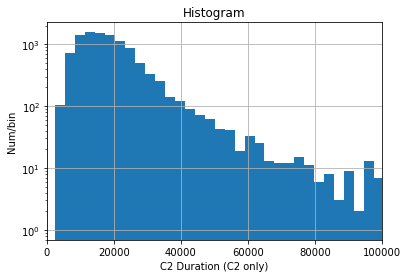

In [5]:
plot_hist(c2_data['Duration_C2'], what='C2 Duration (C2 only)', ylog=True, xhigh=100000)

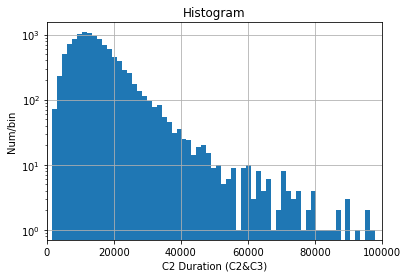

In [6]:
plot_hist(c2_c3_data['Duration_C2'], what='C2 Duration (C2&C3)', ylog=True, xhigh=100000)

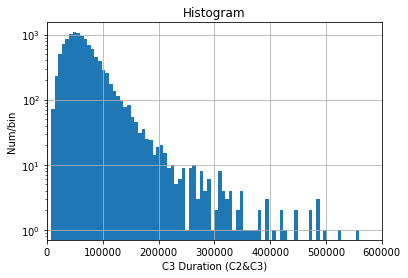

In [7]:
plot_hist(c2_c3_data['Duration_C3'], what='C3 Duration (C2&C3)', ylog=True, xhigh=600000)

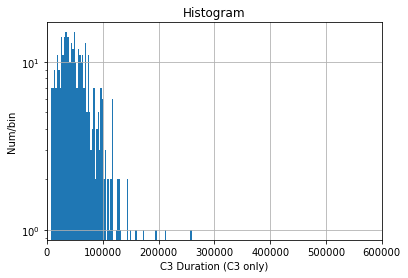

In [8]:
plot_hist(c3_data['Duration_C3'], what='C3 Duration (C3 only)', ylog=True, xhigh=600000)

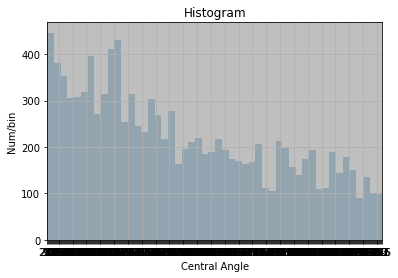

In [9]:
plot_hist(c2_c3_data['Central'], nbins=50, what='Central Angle', ylog=False, xhigh=359)

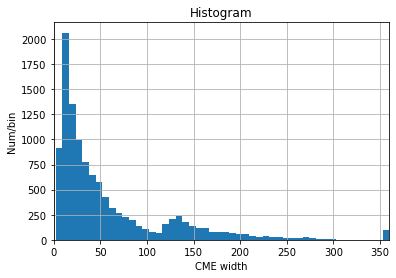

In [10]:
plot_hist(pd.to_numeric(c2_c3_data['Width']), nbins=50, what='CME width', ylog=False, xhigh=359)

In [11]:
c2_c3_data

,CDAW_Id,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,...,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel
5,5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,...,Poor Event; Only 3 points\n,26582.278481,116518.987342,9746.835443,47,158,272,2.500000e+14,3.200000e+28,-12.3
8,8,1996/02/12,05:47:26,91,53,160,100,211,236,2.0*,...,Poor Event\n,26250.000000,115062.500000,9625.000000,53,160,92,1.300000e+15,1.600000e+29,2.0
9,9,1996/02/17,02:06:31,279,73,317,257,378,532,9.9*,...,Very Poor Event\n,13249.211356,58075.709779,4858.044164,73,317,274,3.300000e+14,1.600000e+29,9.9
12,12,1996/03/02,04:11:53,88,36,108,95,120,177,1.0*,...,Poor Event\n,38888.888889,170462.962963,14259.259259,36,108,86,1.500000e+14,8.700000e+27,1.0
16,16,1996/03/07,07:51:56,91,43,60,60,61,75,0.1*,...,Poor Event\n,70000.000000,306833.333333,25666.666667,43,60,87,0.000000e+00,0.000000e+00,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22037,31613,2021/11/23,11:12:10,172,75,199,159,238,376,4.8*,...,Very Poor Event\n,21105.527638,92512.562814,7738.693467,75,199,169,0.000000e+00,0.000000e+00,4.8
22038,31614,2021/11/24,14:26:00,193,211,390,324,458,447,4.0,...,Partial Halo\n,10769.230769,47205.128205,3948.717949,211,390,171,0.000000e+00,0.000000e+00,4.0
22041,31618,2021/11/26,01:25:44,52,63,436,509,362,0,-20.7*,...,Poor Event\n,9633.027523,42224.770642,3532.110092,63,436,67,0.000000e+00,0.000000e+00,-20.7
22042,31619,2021/11/26,05:48:05,137,37,391,487,294,0,-10.4*,...,Poor Event\n,10741.687980,47084.398977,3938.618926,37,391,130,0.000000e+00,0.000000e+00,-10.4


In [12]:
# persist dataset
c2_c3_data.to_csv(CME_Catalog_Filename, index=True, index_label="CDAW_Id")

In [13]:
len(c2_c3_data)

11098

In [14]:
c2_c3_data

,CDAW_Id,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,...,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel
5,5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,...,Poor Event; Only 3 points\n,26582.278481,116518.987342,9746.835443,47,158,272,2.500000e+14,3.200000e+28,-12.3
8,8,1996/02/12,05:47:26,91,53,160,100,211,236,2.0*,...,Poor Event\n,26250.000000,115062.500000,9625.000000,53,160,92,1.300000e+15,1.600000e+29,2.0
9,9,1996/02/17,02:06:31,279,73,317,257,378,532,9.9*,...,Very Poor Event\n,13249.211356,58075.709779,4858.044164,73,317,274,3.300000e+14,1.600000e+29,9.9
12,12,1996/03/02,04:11:53,88,36,108,95,120,177,1.0*,...,Poor Event\n,38888.888889,170462.962963,14259.259259,36,108,86,1.500000e+14,8.700000e+27,1.0
16,16,1996/03/07,07:51:56,91,43,60,60,61,75,0.1*,...,Poor Event\n,70000.000000,306833.333333,25666.666667,43,60,87,0.000000e+00,0.000000e+00,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22037,31613,2021/11/23,11:12:10,172,75,199,159,238,376,4.8*,...,Very Poor Event\n,21105.527638,92512.562814,7738.693467,75,199,169,0.000000e+00,0.000000e+00,4.8
22038,31614,2021/11/24,14:26:00,193,211,390,324,458,447,4.0,...,Partial Halo\n,10769.230769,47205.128205,3948.717949,211,390,171,0.000000e+00,0.000000e+00,4.0
22041,31618,2021/11/26,01:25:44,52,63,436,509,362,0,-20.7*,...,Poor Event\n,9633.027523,42224.770642,3532.110092,63,436,67,0.000000e+00,0.000000e+00,-20.7
22042,31619,2021/11/26,05:48:05,137,37,391,487,294,0,-10.4*,...,Poor Event\n,10741.687980,47084.398977,3938.618926,37,391,130,0.000000e+00,0.000000e+00,-10.4


In [15]:
jul_cme = c2_c3_data[c2_c3_data["Date"] > '2000/07/01']
jul_cme[:10]

,CDAW_Id,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,...,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel
1489,3194,2000/07/04,01:50:05,41,69,492,559,413,397,-6.8*,...,Feature Gap between C2 and C3\n,8536.585366,37418.699187,3130.081301,69,492,35,3.200000e+15,3.800000e+30,-6.8
1491,3200,2000/07/05,07:27:03,60,14,593,703,495,0,-96.5*,...,Only 3 points\n,7082.630691,31045.531197,2596.964587,14,593,55,0.000000e+00,0.000000e+00,-96.5
1494,3209,2000/07/06,07:27:01,77,42,718,695,742,760,4.4,...,Difficult to measure the width\n,5849.582173,25640.668524,2144.846797,42,718,66,2.100000e+14,5.500000e+29,4.4
1496,3214,2000/07/07,06:50:05,80,48,796,793,800,826,2.3*,...,Only 3 points\n,5276.381910,23128.140704,1934.673367,48,796,60,8.700000e+14,2.800000e+30,2.3
1497,3217,2000/07/07,11:50:05,16,118,560,541,582,582,1.9,...,Newly inserted on 2011/10/11\n,7500.000000,32875.000000,2750.000000,118,560,34,0.000000e+00,0.000000e+00,1.9
1498,3221,2000/07/08,20:45:05,189,126,451,641,245,0,-17.9,...,Uncertain Width; Partial Halo\n,9312.638581,40820.399113,3414.634146,126,451,166,0.000000e+00,0.000000e+00,-17.9
1499,3222,2000/07/08,23:50:05,354,161,483,549,409,364,-7.2*,...,Uncertain Width; Partial Halo\n,8695.652174,38115.942029,3188.405797,161,483,339,0.000000e+00,0.000000e+00,-7.2
1501,3225,2000/07/09,11:26:05,169,173,788,1056,507,498,-39.3,...,Uncertain Width; Partial Halo\n,5329.949239,23362.944162,1954.314721,173,788,168,0.000000e+00,0.000000e+00,-39.3
1502,3226,2000/07/09,17:28:17,94,146,609,512,716,739,11.9*,...,Partial Halo\n,6896.551724,30229.885057,2528.735632,146,609,73,0.000000e+00,0.000000e+00,11.9
1503,3228,2000/07/09,21:50:05,83,19,562,643,472,0,-17.9,...,Difficult to measure the width.\n,7473.309609,32758.007117,2740.213523,19,562,80,0.000000e+00,0.000000e+00,-17.9


In [16]:
mar_cme = c2_c3_data[c2_c3_data["Date"] > '2000/03/20']
mar_cme[:10]

,CDAW_Id,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,...,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel
1258,2675,2000/03/21,09:06:05,323,64,396,345,452,447,3.8,...,Part of previous event?\n,10606.060606,46489.898990,3888.888889,64,396,342,2.200000e+15,1.800000e+30,3.8
1270,2704,2000/03/30,01:31:23,168,25,416,421,412,407,-0.5*,...,Newly inserted on 2006/11/06\n,10096.153846,44254.807692,3701.923077,25,416,169,0.000000e+00,0.000000e+00,-0.5
1273,2710,2000/03/31,03:54:05,88,27,328,0,627,1461,89.2*,...,Newly inserted on 2007/06/19; Poor Event\n,12804.878049,56128.048780,4695.121951,27,328,89,0.000000e+00,0.000000e+00,89.2
1274,2711,2000/03/31,07:31:24,113,101,483,448,521,521,3.0,...,Partial Halo?\n,8695.652174,38115.942029,3188.405797,101,483,86,7.100000e+15,8.300000e+30,3.0
1275,2713,2000/03/31,11:06:05,61,11,375,491,258,0,-25.4*,...,Newly inserted on 2007/06/19; Poor Event\n,11200.000000,49093.333333,4106.666667,11,375,60,0.000000e+00,0.000000e+00,-25.4
1276,2714,2000/03/31,12:54:05,46,55,328,337,319,319,-0.5*,...,Newly inserted on 2007/06/19\n,12804.878049,56128.048780,4695.121951,55,328,50,0.000000e+00,0.000000e+00,-0.5
1277,2715,2000/03/31,18:06:05,35,87,542,613,477,0,-23.5*,...,Partial Halo?\n,7749.077491,33966.789668,2841.328413,87,542,17,4.100000e+14,6.100000e+29,-23.5
1278,2718,2000/03/31,23:30:05,168,64,456,554,361,0,-16.6,...,Newly inserted on 2007/06/19\n,9210.526316,40372.807018,3377.192982,64,456,159,0.000000e+00,0.000000e+00,-16.6
1283,2737,2000/04/05,00:30:09,291,7,641,821,443,0,-58.4*,...,Only 3 points\n,6552.262090,28720.748830,2402.496100,7,641,292,0.000000e+00,0.000000e+00,-58.4
1289,2748,2000/04/07,01:31:21,286,13,479,552,395,161,-11.6*,...,Poor Event\n,8768.267223,38434.237996,3215.031315,13,479,278,0.000000e+00,0.000000e+00,-11.6
